In [1]:
import numpy as np
import pandas as pd
from platform import python_version

print(python_version())

3.7.1


In [2]:
class LDA():
    def __init__(self):
        self.w1 = None
        self.w0 = None
    
    def fit(self, X_train, y_train):
        data = X_train
        data['quality'] = y_train
        
        u0 = data.loc[data['quality']==0].iloc[:, :len(data.columns)-1]
        u1 = data.loc[data['quality']==1].iloc[:, :len(data.columns)-1]
        
        first_class_count = float(len(u0))
        second_class_count = float(len(u1))
        
        first_class_prob = first_class_count/len(y_train)
        second_class_prob = second_class_count/len(y_train)

        first_average = []
        second_average = []
        for column in u0:
            column = u0[column].values
            first_average.append(np.mean(column))

        for column in u1:
            column = u1[column].values
            second_average.append(np.mean(column))

        first_average = np.transpose(np.expand_dims(first_average, axis=1))
        second_average = np.transpose(np.expand_dims(second_average, axis=1))
        
        cov0 = np.cov(np.transpose(u0))
        cov1 = np.cov(np.transpose(u1))
        covariance_matrix = cov1 + cov0
        
        division = second_class_prob/first_class_prob
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        class_two = 0.5*float(np.matmul(np.matmul(second_average,inv_covariance_matrix),np.transpose(second_average)))
        class_one = 0.5*float(np.matmul(np.matmul(first_average,inv_covariance_matrix),np.transpose(first_average)))
        
        self.w0 = np.log(division) - class_two + class_one
        self.w1 = np.matmul(inv_covariance_matrix, (np.transpose(second_average)-np.transpose(first_average)))
        
    def predict(self, X_test):
        X_test = X_test.to_numpy()
        return [1 if np.dot(x,self.w1) + self.w0 > 0 else 0 for x in X_test]

0.7498432601880878
0.015151154825823888


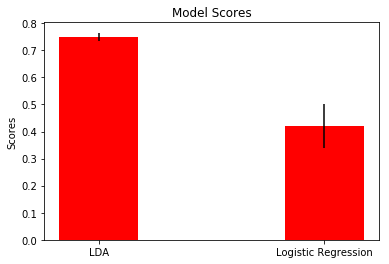

In [42]:
data = pd.read_csv("winequality-red.csv", sep=';').astype('float32')
X_train = data.iloc[:, :len(data.columns)-1]
y_train = data.iloc[:, len(data.columns)-1:].values
y_train = [0 if i < 6 else 1 for i in y_train]
data['quality'] = y_train

X_train_new = X_train.values

new_feat = []
for column in X_train_new:
    new_feat.append([x**2 for x in column])
    
X_train_new = pd.DataFrame(X_train_new)
new_feat = pd.DataFrame(new_feat)

X_train_new = pd.concat([X_train_new, new_feat], axis=1, sort=False)
data_new = X_train_new
data_new['quality'] = y_train

def k_fold(data, n):
    results = []
    results_new = []
    fold_length = int(len(data)/5)
    for i in range(n):
        start = fold_length*i
        end = start + fold_length
        temp_data = data
        
        temp_data_test = temp_data.iloc[start:end]
        
        X_test = temp_data_test.iloc[:, :len(temp_data_test.columns)-1]
        y_test = temp_data_test.iloc[:, len(temp_data_test.columns)-1:].values
        
        top = temp_data.iloc[0:start]
        bottom = temp_data.iloc[end:len(temp_data)]
        
        temp_data_train = pd.concat([top,bottom])
        
        X_train = temp_data_test.iloc[:, :len(temp_data_train.columns)-1]
        y_train = temp_data_test.iloc[:, len(temp_data_train.columns)-1:].values
        
        lda = LDA()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        
        correct = 0.0
        for pred,true in zip(y_pred, y_test):
            if pred == true:
                correct += 1 
        results.append(correct/len(y_train))
        
    return results
        
results = k_fold(data, 5)
results_new = k_fold(data_new, 5)

avg = np.mean(results)
std = np.std(results)

avg_new = np.mean(results_new)
std_new = np.std(results_new)

print(avg)
print(std)

import matplotlib.pyplot as plt
N = 2
lda_means = (avg, avg_new)
lda_std = (std, std_new)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, lda_means, width, color='r', yerr=lda_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Model Scores')
ax.set_xticks(ind)
ax.set_xticklabels(('LDA', 'Logistic Regression'))

plt.show()

In [7]:
data = pd.read_csv("winequality-red.csv", sep=';').astype('float32')

In [27]:
X_train = data.iloc[:, :len(data.columns)-1]
y_train = data.iloc[:, len(data.columns)-1:].values
y_train = [0 if i < 6 else 1 for i in y_train]

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=38)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
mean = clf.score(X_test, y_test)
print(mean)



0.74375


In [38]:
u0 = data
u0 = data.loc[data['result']==0].iloc[:, :len(u0.columns)-1]

In [39]:
u1 = data
u1 = data.loc[data['result']==1].iloc[:, :len(u1.columns)-1]

In [40]:
first_class_count = float(len(u0))
second_class_count = float(len(u1))

first_class_prob = first_class_count/len(y_train)
second_class_prob = second_class_count/len(y_train)

first_average = []
second_average = []
for column in u0:
    column = u0[column].values
    first_average.append(np.mean(column))

for column in u1:
    column = u1[column].values
    second_average.append(np.mean(column))

first_average = np.transpose(np.expand_dims(first_average, axis=1))
second_average = np.transpose(np.expand_dims(second_average, axis=1))

In [41]:
# covariance_matrix_one = (1.0 / (len(y_train)-1)) * (u0 - u0.mean(axis=0)).T.dot(u0 - u0.mean(axis=0))
# covariance_matrix_two = (1.0 / (len(y_train)-1)) * (u1 - u1.mean(axis=0)).T.dot(u1 - u1.mean(axis=0))
# covariance_matrix = covariance_matrix_one + covariance_matrix_two
# covariance_matrix

cov0 = np.cov(np.transpose(u0))
cov1 = np.cov(np.transpose(u1))
covariance_matrix = cov1 + cov0

In [48]:
division = second_class_prob/first_class_prob
inv_covariance_matrix = np.linalg.inv(covariance_matrix)
class_two = 0.5*float(np.matmul(np.matmul(second_average,inv_covariance_matrix),np.transpose(second_average)))
class_one = 0.5*float(np.matmul(np.matmul(first_average,inv_covariance_matrix),np.transpose(first_average)))

NameError: name 'second_class_prob' is not defined

In [49]:
w0 = np.log(division) - class_two + class_one
w1 = np.matmul(inv_covariance_matrix, (np.transpose(second_average)-np.transpose(first_average)))

NameError: name 'division' is not defined

In [50]:
correct = 0.0
for x,y in zip(X_train.values, y_train):
    value = np.dot(x,w1) + w0
    if value > 0:
        value = 1
    else:
        value = 0
    if y == value:
        correct += 1
    
print(correct/len(y_train))

NameError: name 'w1' is not defined

In [19]:
cov0 = np.cov(np.transpose(u0))
cov1 = np.cov(np.transpose(u1))

NameError: name 'y_traincov1' is not defined

In [37]:
data = pd.read_csv("winequality-red.csv", sep=';').astype('float32')
X_train = data.iloc[:, :len(data.columns)-1]
y_train = data.iloc[:, len(data.columns)-1:].values
y_train = [0 if i < 6 else 1 for i in y_train]
data['quality'] = y_train

X_train_new = X_train.values

new_feat = []
for column in X_train_new:
    new_feat.append([x**2 for x in column])
    
X_train_new = pd.DataFrame(X_train_new)
new_feat = pd.DataFrame(new_feat)

X_train_new = pd.concat([X_train_new, new_feat], axis=1, sort=False)
X_train_new.shape

(1599, 22)